# **scatter plot and compare all tissue coefs**

In [127]:
# args = commandArgs(trailingOnly=TRUE)
# tissue = args[1]
# tissue_predOn = args[2]
# model_name = args[3]
tissue = "germline"
tissue_predOn = "blood"
model_name = "model3"
tmp_file_path = "../../../"


library(dplyr)
library(ggplot2)
library(stringr)

#reading in data
if (tissue_predOn =="liver"){ #oif conditional as different files to compare to liver 
    tissue_coefs <- read.csv(paste(tmp_file_path,"data/",tissue,"/dataframes/",model_name,"/",tissue,"_onLiver_coefDF_bootstrap.csv",sep=""))
}else{tissue_coefs <- read.csv(paste(tmp_file_path,"data/",tissue,"/dataframes/",model_name,"/",tissue,"_coefDF_bootstrap.csv",sep=""))}
if (tissue=="liver"){
   tissue_predOn_coefs <- read.csv(paste(tmp_file_path,"data/",tissue_predOn,"/dataframes/",model_name,"/",tissue_predOn,"_onLiver_coefDF_bootstrap.csv",sep=""))
}else{tissue_predOn_coefs <- read.csv(paste(tmp_file_path,"data/",tissue_predOn,"/dataframes/",model_name,"/",tissue_predOn,"_coefDF_bootstrap.csv",sep=""))}


tissue_coefs_reduced <- data.frame(tissue_coefs$name, tissue_coefs$mean_est,tissue_coefs$quant025,tissue_coefs$quant975)
tissue_predOn_coefs_reduced <-data.frame(tissue_predOn_coefs$name,tissue_predOn_coefs$mean_est,tissue_predOn_coefs$quant025,tissue_predOn_coefs$quant975)
colnames(tissue_coefs_reduced) <- c("name",'tissue_est','tissue_quant025','tissue_quant975')
colnames(tissue_predOn_coefs_reduced) <- c("name",'tissue_predOn_est','tissue_predOn_quant025','tissue_predOn_quant975')
all_coefs <- merge(tissue_coefs_reduced,tissue_predOn_coefs_reduced,on="name",all=T)#for some reason the dim b/t germ and blood are different so need a merge... 
colnames(all_coefs) <- c("name","tissue_est","tissue_quant025","tissue_quant975","tissue_predON_est","tissue_predON_quant025","tissue_predON_quant975")

#create col that categorizes 
all_coefs<-all_coefs %>%
    mutate(type = case_when(        
        str_detect(name, 'percent') ~ 'sequence',
        str_detect(name, 'Chromosome') ~ 'sequence',
        str_detect(name, 'Repeats') ~ 'sequence',
        str_detect(name, 'site') ~ 'sequence',
        str_detect(name, 'annot') ~ 'sequence',
        str_detect(name, 'content') ~ 'sequence',
        
        str_detect(name, 'triplet') ~ 'triplet',
        
        str_detect(name, 'DNAse') ~ 'tissue specific',
        str_detect(name, 'Transcription') ~ 'tissue specific',
        str_detect(name, 'H3k') ~ 'tissue specific',
        
        str_detect(name, 'recomb') ~ 'global',
        str_detect(name, 'lamin') ~ 'global',
        str_detect(name, 'Replication') ~ 'global',
    ))

all_sign_coefs <- filter(all_coefs[order(-all_coefs$tissue_est),],(tissue_quant025*tissue_quant975>0)&(tissue_predON_quant025*tissue_predON_quant975>0))


#plotting
ggplot(all_coefs, aes(y = tissue_est, x = tissue_predON_est)) +
    geom_point(aes(color=type) )+
    theme_light()+
#     scale_y_continuous(breaks=seq(-0.75,1.75,0.75)) +
#     scale_x_continuous(breaks=seq(-0.75,1.75,0.75)) +
    geom_abline(intercept=0, slope=1, col="grey",linetype="dashed")+ #http://www.sthda.com/english/wiki/ggplot2-line-types-how-to-change-line-types-of-a-graph-in-r-software
    geom_abline(intercept=0, slope=0, col="cornflowerblue")+
    geom_vline(xintercept=0,col="cornflowerblue") + #http://www.sthda.com/english/wiki/ggplot2-add-straight-lines-to-a-plot-horizontal-vertical-and-regression-lines
    labs(
        x = paste(tissue_predOn," coefficient values",sep=""),
        y = paste(tissue," coefficient values",sep=""),
        color = "Predictor class"#https://stackoverflow.com/questions/14622421/how-to-change-legend-title-in-ggplot
        ) +
    theme(
    axis.text = element_text(size = 20, family = 'Helvetica', color = 'black'),
    axis.title = element_text(size = 20, family = 'Helvetica'),
    legend.title = element_text(size=12, family = 'Helvetica'),
    legend.text = element_text(size = 12, family = 'Helvetica')
    )   
ggsave(paste(tmp_file_path,"analysis/global/plots/",model_name,"/coefScatter_",tissue,"_on_",tissue_predOn,".pdf",sep=""))

#writing some infor on how wel they match to file 
error_output_file = paste(tmp_file_path,"analysis/global/plots/",model_name,"/coefScatter_",tissue,"_on_",tissue_predOn,"_textOutput.txt",sep="")

MAE = mean(abs(all_coefs$tissue_est - all_coefs$tissue_predON_est),na.rm=TRUE)
string_to_print = paste("mean absolute error is",round(MAE,4),sep=" ")
cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)

fit<-lm(tissue_est~tissue_predON_est,data=all_coefs)
string_to_print = paste("r-squared is",summary(fit)$r.squared,sep=" ")
cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)

# **EXTRA NOT IN SCRIPT--> get the fold coomp plot**

In [8]:
all_coefs <- all_coefs %>% 
    mutate(fold_change = tissue_coefs/tissue_predOn_coefs)  

all_ceofs <- all_coefs[order(all_coefs$fold_change),] 

head_all_coefs <- head(all_ceofs,n=10)
tail_all_coefs <- tail(all_ceofs,n=10)
fold_plotting <- rbind(head_all_coefs,tail_all_coefs)

posNeg_log10 <- function(number) {
    if (number > 0) {
         return(log10(number))
    } else {
         return(-log10(-number))
    }
}
fold_plotting$log10_chnage <- as.numeric(lapply(fold_plotting$fold_change, posNeg_log10))



Saving 6.67 x 6.67 in image



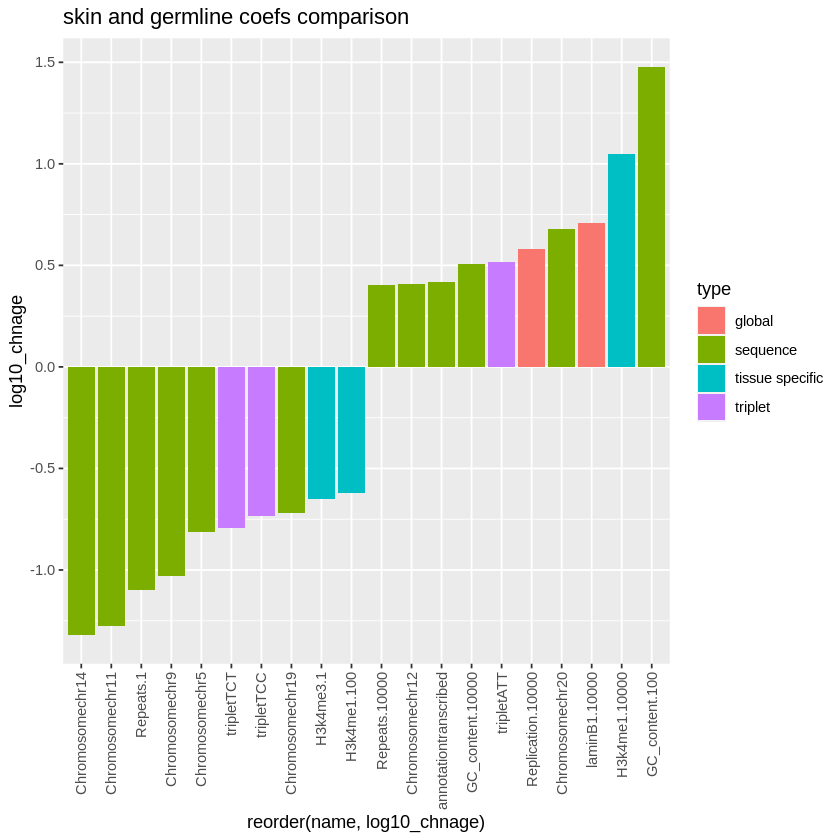

In [9]:
ggplot(data=fold_plotting,aes(x=reorder(name,log10_chnage),y=log10_chnage))+
    geom_bar(stat="identity",aes(fill=type))+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+#https://stackoverflow.com/questions/1330989/rotating-and-spacing-axis-labels-in-ggplot2
    ggtitle(paste(tissue,"and",tissue_predOn,"coefs comparison",sep=" "))
ggsave(paste(tmp_file_path,"analysis/global/plots/",model_name,"/coefFoldChange_",tissue,"_on_",tissue_predOn,".pdf",sep=""))